In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import ot
import cvxpy as cp
import seaborn as sns

# Supplementary Packages
#import scipy.stats as stats
#import scipy.special as sps
#import time as t

## Functions

In [2]:
def baryc_proj(source, target, method = 'emd'):
    
    n1 = source.shape[0]
    n2 = target.shape[0]   
    p = source.shape[1]
    a_ones, b_ones = np.ones((n1,)) / n1, np.ones((n2,)) / n2
    
    M = ot.dist(source, target)
    M = M.astype('float64')
    M /= M.max()
    
    if method == 'emd':
        OTplan = ot.emd(a_ones, b_ones, M, numItermax = 1e7)
        
    elif method == 'entropic':
        OTplan = ot.bregman.sinkhorn_stabilized(a_ones, b_ones, M, reg = 5*1e-3)
    
    # initialization
    OTmap = np.empty((0, p))

    for i in range(n1):
        
        # normalization
        OTplan[i,:] = OTplan[i,:] / sum(OTplan[i,:])
    
        # conditional expectation
        OTmap = np.vstack([OTmap, (target.T @ OTplan[i,:])])
    
    OTmap = np.array(OTmap)
    
    return(OTmap)

In [3]:
def DSCreplication(target, controls, method = 'emd'):
    
    n = target.shape[0]
    d = target.shape[1]
    J = len(controls)
    S = np.mean(target)*n*d*J
    
    
    # Barycentric Projection
    G_list = []
    proj_list = []
    for i in range(len(controls)):
        temp = baryc_proj(target, controls[i], method)
        G_list.append(temp)
        proj_list.append(temp - target)
    
    
    # Obtain optimal weights
    mylambda = cp.Variable(J)

    objective = cp.Minimize(
                    cp.sum_squares(
                    cp.sum([a*b for a,b in zip(mylambda, proj_list)], axis = 0))/S
                    )
    constraints = [mylambda >= 0, mylambda <= 1, cp.sum(mylambda) == 1]

    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    
    weights = mylambda.value
    projection = sum([a*b for a,b in zip(weights, G_list)])
    
    return(weights, projection)

## Mixed Multivariate Normal

In [4]:
def mixed_multi_gauss(mean1, mean2, mean3, cov1, cov2, cov3, samplesize, partition1, partition2):
    
    size1 = int(samplesize * partition1)
    size2 = int(samplesize * partition2)
    size3 = int(samplesize - size1 - size2)
    
    gauss1 = np.random.multivariate_normal(mean = mean1, cov = cov1, size = size1)
    gauss2 = np.random.multivariate_normal(mean = mean2, cov = cov2, size = size2)
    gauss3 = np.random.multivariate_normal(mean = mean3, cov = cov3, size = size3)
    
    mixed = np.concatenate((gauss1, gauss2, gauss3), axis = 0)
    np.random.shuffle(mixed)
    
    return(mixed)

In [5]:
np.random.seed(31)

dim = 10
obs = 10000

mu1 = [10]*dim
mu2 = [50]*dim
mu3 = [200]*dim
mu4 = [-50]*dim
mu5 = [-100]*dim

covmat = np.full((dim, dim), 0.5)
np.fill_diagonal(covmat, 1)


X1 = np.random.multivariate_normal(mean = mu1, cov = covmat, size = obs)
X2 = np.random.multivariate_normal(mean = mu2, cov = covmat, size = obs)
X3 = np.random.multivariate_normal(mean = mu3, cov = covmat, size = obs)
X4 = np.random.multivariate_normal(mean = mu4, cov = covmat, size = obs)


Y1 = mixed_multi_gauss(mu1, mu2, mu3, covmat, covmat, covmat, obs, 0.3, 0.6)
Y2 = mixed_multi_gauss(mu1, mu2, mu3, covmat, covmat, covmat, obs, 0.8, 0.1)
Y3 = mixed_multi_gauss(mu2, mu3, mu4, covmat, covmat, covmat, obs, 0.2, 0.7)
Y4 = mixed_multi_gauss(mu1, mu3, mu4, covmat, covmat, covmat, obs, 0.2, 0.2)

## X

In [6]:
weightsX, projectionX = DSCreplication(X1, [X2, X3, X4])
weightsX

array([0.36424792, 0.09429699, 0.54145509])

In [8]:
meansX = pd.concat((pd.DataFrame(X1).describe().iloc[1,:], 
           pd.DataFrame(projectionX).describe().iloc[1,:]), axis = 1).transpose()
meansX

,0,1,2,3,4,5,6,7,8,9
mean,10.011210,9.997860,10.010733,9.999980,10.010595,9.989504,10.006829,10.002123,10.005622,10.002296
mean,10.005615,10.001172,10.006146,10.000823,10.006908,10.007984,10.001690,10.003112,10.005313,10.000683


<AxesSubplot:ylabel='Count'>

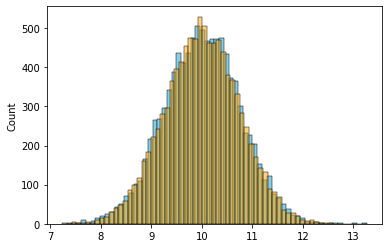

In [7]:
sns.histplot(np.mean(X1, axis = 1), color = 'skyblue', alpha = 1)
sns.histplot(np.mean(projectionX, axis = 1), color = 'orange', alpha = 0.5)

# Y

In [11]:
weightsY, projectionY = DSCreplication(Y1, [Y2, Y3, Y4])
weightsY

array([ 8.20419571e-01,  1.79580429e-01, -1.21374041e-13])

In [12]:
meansY = pd.concat((pd.DataFrame(Y1).describe().iloc[1,:], 
           pd.DataFrame(projectionY).describe().iloc[1,:]), axis = 1).transpose()
meansY

,0,1,2,3,4,5,6,7,8,9
mean,52.993670,52.991194,52.991719,52.997722,52.997866,52.996947,53.006997,52.994608,52.992457,53.006183
mean,53.113973,53.106591,53.108098,53.121586,53.114572,53.112659,53.112439,53.121735,53.106264,53.122041


<AxesSubplot:ylabel='Count'>

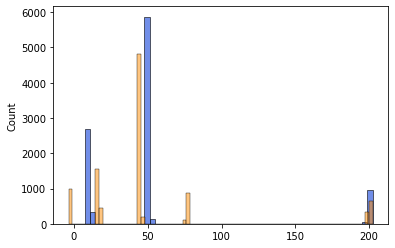

In [13]:
sns.histplot(np.mean(Y1, axis = 1), color = 'royalblue')
sns.histplot(np.mean(projectionY, axis = 1), color = 'darkorange', alpha = 0.5)